In [112]:
import glob
import pandas as pd
from sklearn import preprocessing

In [113]:
def merge_data_frames():
    extension = 'csv'
    all_filenames = [i for i in glob.glob('*.{}'.format(extension))]
    #combine all files in the list
    combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])
    #export to csv
    combined_csv.to_csv( "combined_csv.csv", index=False, encoding='utf-8-sig')
    

In [114]:
# merge_data_frames()
df=pd.read_csv("combined_csv.csv",index_col=0)
print(df.shape)
copy=df.drop_duplicates(keep='first',ignore_index=False).copy()
copy.shape

(15792, 57)


(15166, 57)

In [115]:
# def fill_empty_values(df):
#     df.fillna("Empty", inplace=True)
# fill_empty_values(copy)


In [116]:
def divide_details_col():
    dictionary = {}
    sorted_dict = {}
    list1 = []

    for i in copy['Details']:
        if isinstance(i, str):
            for j in i.split(', '):
                if j not in dictionary:
                    dictionary[j] = 1
                else:
                    dictionary[j] += 1

    sorted_keys = sorted(dictionary, key=dictionary.get, reverse=True)

    for w in sorted_keys:
        if dictionary[w] >= 100 and w != 'Empty':
            sorted_dict[w] = dictionary[w]
            list1.append(w)

    for x in list1:
        copy[x] = copy['Details'].astype(str).str.contains(x).astype(int)


In [117]:
def remove_empty_cols(col_list):   
    copy.drop(axis=1, index=None, columns=col_list, inplace=True)

col_list=['Details','Composition','Mouw lengte','Materiaal','Bra Type','Chest pad','Panty Type','Item NamePrice','Doorzichtig','Arabian Clothing','Care Instructions','Kleur','Lengte','Neklijn','Patroon type','Seizoen','Stijl','Type mouwen','Stof','Type fit']
remove_empty_cols(col_list)

In [118]:
# filterd all the damaged items (the items with incorrect number reviews)  
sum_cols=(copy['1 Star Reviews'] + copy['2 Stars Reviews'] + copy['3 Stars Reviews']+copy['4 Stars Reviews'] + copy['5 Stars Reviews'])
copy=copy[~((sum_cols>copy['Reviews Num']) & ((copy['Reviews Num']==copy['1 Star Reviews']) | (copy['Reviews Num']==copy['2 Stars Reviews']) | (copy['Reviews Num']==copy['3 Stars Reviews']) | (copy['Reviews Num']==copy['4 Stars Reviews']) | (copy['Reviews Num']==copy['5 Stars Reviews'])))]

In [119]:
# filterd all items with low reviews(less then 50)
copy=copy[copy["Reviews Num"] > 50]

In [120]:
copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13847 entries, 0 to 1376
Data columns (total 37 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   SKU              13847 non-null  object 
 1   Reviews Num      13847 non-null  int64  
 2   1 Star Reviews   13847 non-null  int64  
 3   1 Star Images    13847 non-null  int64  
 4   2 Stars Reviews  13847 non-null  int64  
 5   2 Stars Images   13847 non-null  int64  
 6   3 Stars Reviews  13847 non-null  int64  
 7   3 Stars Images   13847 non-null  int64  
 8   4 Stars Reviews  13847 non-null  int64  
 9   4 Stars Images   13847 non-null  int64  
 10  5 Stars Reviews  13847 non-null  int64  
 11  5 Stars Images   13847 non-null  int64  
 12  Points Earnning  13847 non-null  int64  
 13  Style            12904 non-null  object 
 14  Color            13846 non-null  object 
 15  Pattern Type     13641 non-null  object 
 16  Length           12970 non-null  object 
 17  Type             8

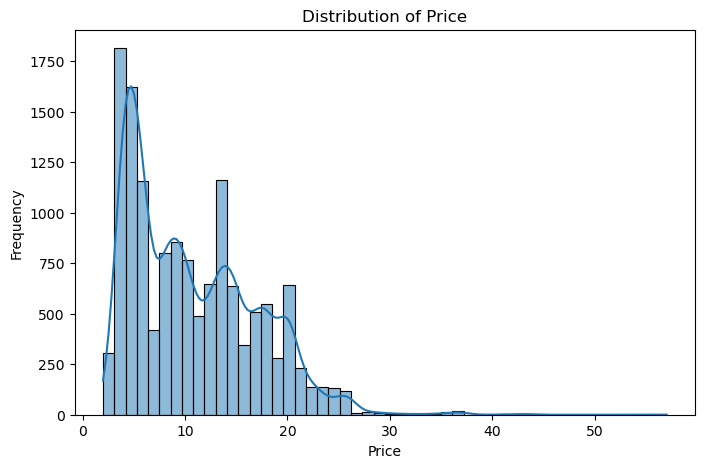

Mean Price: 10.78
Median Price: 9.00


In [121]:
import matplotlib.pyplot as plt
import seaborn as sns

copy['Price'] = pd.to_numeric(copy['Price'], errors='coerce')

plt.figure(figsize=(8,5))
sns.histplot(copy['Price'], bins=50, kde=True)
plt.title('Distribution of Price')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

mean_price = copy['Price'].mean()
median_price = copy['Price'].median()

print(f"Mean Price: {mean_price:.2f}")
print(f"Median Price: {median_price:.2f}")


In [122]:
def smart_fill_missing(df, verbose=True, fill_unknown=True):
    filled_columns = []

    for col in df.columns:
        missing = df[col].isnull().sum()
        total = len(df[col])

        if missing > 0:
            dtype = df[col].dtype

          
            if dtype == 'object':
                non_na_unique = df[col].dropna().nunique()

                if non_na_unique > 0:
                    mode_value = df[col].mode()[0]
                    df[col].fillna(mode_value, inplace=True)
                    filled_columns.append((col, 'mode', mode_value))
                    if verbose:
                        print(f"✔ Filled {missing} missing in '{col}' (categorical) with mode: '{mode_value}'")
                elif fill_unknown:
                    df[col].fillna('Unknown', inplace=True)
                    filled_columns.append((col, 'fill: Unknown', 'Unknown'))
                    if verbose:
                        print(f"⚠ '{col}' had no valid mode → filled with 'Unknown'")
                else:
                    if verbose:
                        print(f"⚠ Skipped '{col}' (categorical) – no valid values")

            
            elif dtype in ['float64', 'int64']:
                if df[col].dropna().shape[0] > 0:
                    median_value = df[col].median()
                    df[col].fillna(median_value, inplace=True)
                    filled_columns.append((col, 'median', median_value))
                    if verbose:
                        print(f"✔ Filled {missing} missing in '{col}' (numeric) with median: {median_value:.2f}")
                else:
                    if verbose:
                        print(f"⚠ Skipped '{col}' (numeric) – all values missing")

            else:
                if verbose:
                    print(f"⚠ Skipped '{col}' – unsupported dtype: {dtype}")

    return pd.DataFrame(filled_columns, columns=['Column', 'Method', 'Value'])


In [123]:
report_df = smart_fill_missing(copy)


✔ Filled 943 missing in 'Style' (categorical) with mode: 'Casual'
✔ Filled 1 missing in 'Color' (categorical) with mode: 'Black'
✔ Filled 206 missing in 'Pattern Type' (categorical) with mode: 'Plain'
✔ Filled 877 missing in 'Length' (categorical) with mode: 'Crop'
✔ Filled 5276 missing in 'Type' (categorical) with mode: 'Pullovers'
✔ Filled 2023 missing in 'Neckline' (categorical) with mode: 'Round Neck'
✔ Filled 3605 missing in 'Sleeve Length' (categorical) with mode: 'Long Sleeve'
✔ Filled 4908 missing in 'Sleeve Type' (categorical) with mode: 'Regular Sleeve'
✔ Filled 7889 missing in 'Placket Type' (categorical) with mode: 'Pullovers'
✔ Filled 769 missing in 'Season' (categorical) with mode: 'Spring/Fall'
✔ Filled 39 missing in 'Material' (categorical) with mode: 'Polyester'
✔ Filled 1 missing in 'Fabric' (categorical) with mode: 'Slight Stretch'
✔ Filled 70 missing in 'Sheer' (categorical) with mode: 'No'
✔ Filled 459 missing in 'Fit Type' (categorical) with mode: 'Regular Fit'
✔ 

In [124]:
copy.shape

(13847, 37)

In [125]:
#save results table 
copy.to_csv( "combined_with_classification_2.csv", index=False, encoding='utf-8-sig')